## Dependencias

In [1]:
import numpy as np
import pandas as pd
import datetime as datetime

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import f_regression

import seaborn as sns
import cufflinks as cf
import matplotlib.pyplot as plt

cf.go_offline()

## Lectura de datos

In [3]:
ruta = '/home/oscarjarillo/Documentos/Análisis Multivariado/Regresión_Lineal/Real estate.csv'
df = pd.read_csv(ruta)
df.head()

,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


In [4]:
df.shape

(414, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   No                                      414 non-null    int64  
 1   X1 transaction date                     414 non-null    float64
 2   X2 house age                            414 non-null    float64
 3   X3 distance to the nearest MRT station  414 non-null    float64
 4   X4 number of convenience stores         414 non-null    int64  
 5   X5 latitude                             414 non-null    float64
 6   X6 longitude                            414 non-null    float64
 7   Y house price of unit area              414 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 26.0 KB


## Derfinición de variables

In [7]:
um = ['No']
vart = ['Y house price of unit area']
varc = [v for v in df.columns if v not in um and v not in vart]

## Análisis exploratorio

### Valores nulos

In [9]:
nulos = df.describe().T[['count']]/len(df)
nulos

,count
No,1.0
X1 transaction date,1.0
X2 house age,1.0
X3 distance to the nearest MRT station,1.0
X4 number of convenience stores,1.0
X5 latitude,1.0
X6 longitude,1.0
Y house price of unit area,1.0


### Valores extremos

In [10]:
X = df[varc].copy()

In [ ]:
X.hist(figsize=(10,10),color='red')

In [12]:
for v,li,ls in X.describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X[f'ex_{v}'] = ((X[v]<li)|(X[v]>ls)).astype(int)
X['ex_'] = X.filter(like='ex_').max(axis=1)
X['ex_'].value_counts(1)

0    0.934783
1    0.065217
Name: ex_, dtype: float64

In [13]:
X[um+vart] = df[um+vart]

In [15]:
X = X.loc[X['ex_']==0].drop(X.filter(like='ex_').columns,axis=1).reset_index(drop=True)

array([[<AxesSubplot:title={'center':'X1 transaction date'}>,
        <AxesSubplot:title={'center':'X2 house age'}>],
       [<AxesSubplot:title={'center':'X3 distance to the nearest MRT station'}>,
        <AxesSubplot:title={'center':'X4 number of convenience stores'}>],
       [<AxesSubplot:title={'center':'X5 latitude'}>,
        <AxesSubplot:title={'center':'X6 longitude'}>]], dtype=object)

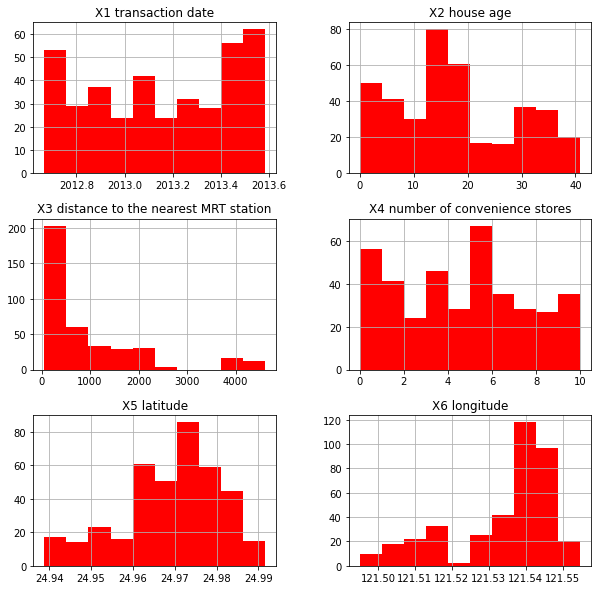

In [17]:
X[varc].hist(figsize=(10,10),color='red')

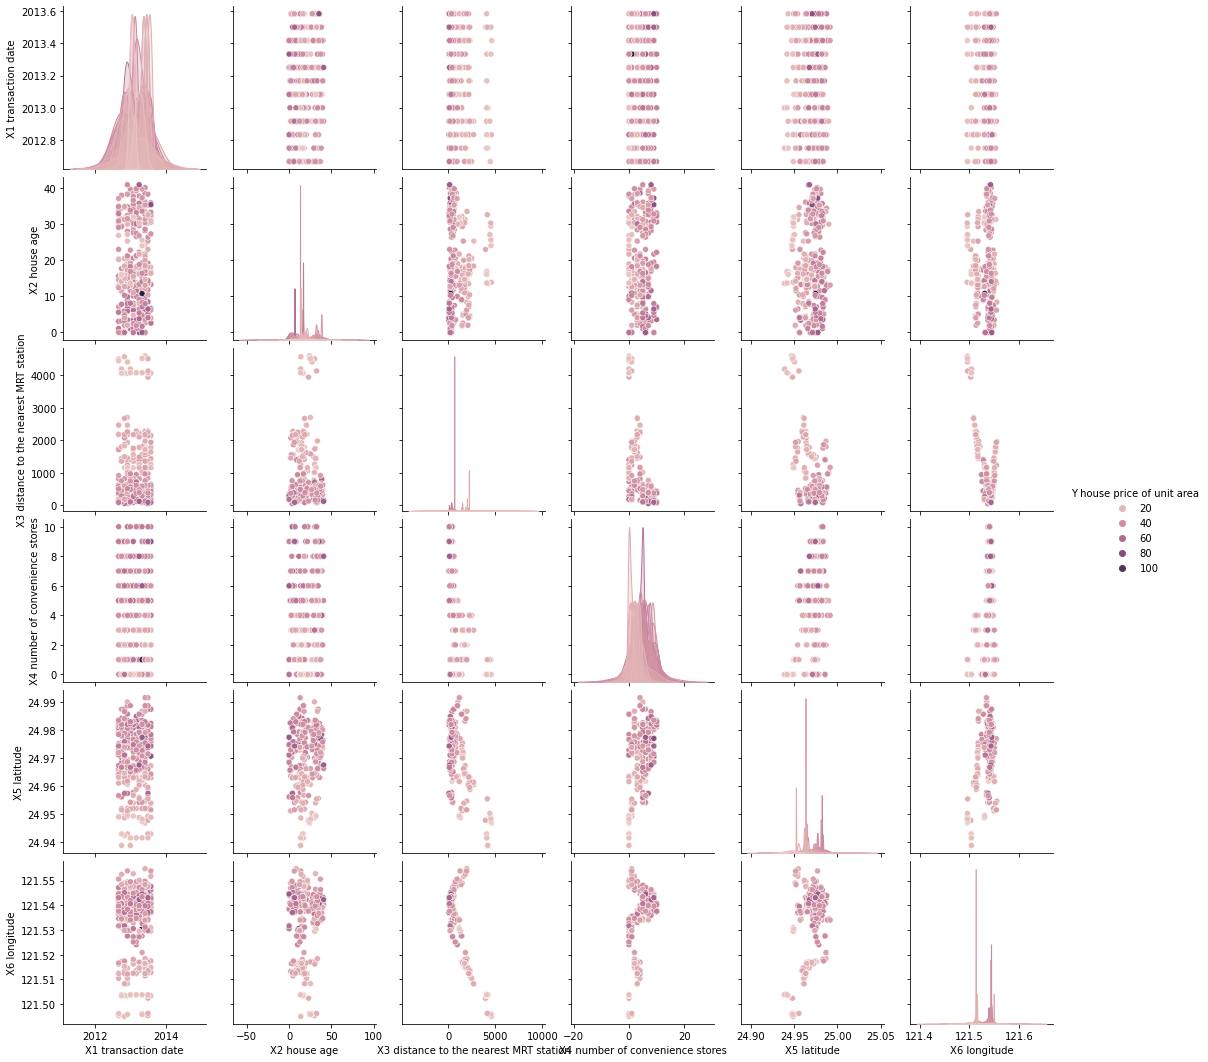

In [18]:
sns.pairplot(data=X[varc+vart],hue=vart[0])

## Partición

In [19]:
Xt,Xv,yt,yv = train_test_split(X[um+varc],X[um+vart],train_size=0.7)
Xt.reset_index(drop=True,inplace=True)
Xv.reset_index(drop=True,inplace=True)
yt.reset_index(drop=True,inplace=True)
yv.reset_index(drop=True,inplace=True)

## Aprendizaje

In [20]:
hp = dict(alpha=np.arange(0.1,2,0.1))
modelo = Ridge()
grid = GridSearchCV(param_grid=hp,
                   cv=5,
                   scoring='neg_mean_absolute_error',
                   n_jobs=-1,
                   verbose=True,
                   estimator=modelo)

In [22]:
grid.fit(Xt[varc],yt[vart[0]])

Fitting 5 folds for each of 19 candidates, totalling 95 fits


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9])},
             scoring='neg_mean_absolute_error', verbose=True)

In [23]:
modelo = grid.best_estimator_
modelo

Ridge(alpha=0.1)

In [26]:
modelo.fit(Xt[varc],yt[vart[0]])

Ridge(alpha=0.1)

In [27]:
modelo.coef_,modelo.intercept_

(array([ 6.77100620e+00, -2.97937877e-01, -6.34681762e-03,  9.92222161e-01,
         4.14000901e+01, -2.44300027e+00]),
 -14322.096444213501)

## Validación del modelo

In [28]:
St = Xt.merge(yt,on=um,how='inner')
Sv = Xv.merge(yv,on=um,how='inner')

In [29]:
St['y^'] = modelo.predict(Xt[varc])
Sv['y^'] = modelo.predict(Xv[varc])

In [30]:
print(mean_absolute_error(y_pred=St['y^'],y_true=St[vart[0]]))
print(mean_absolute_error(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

6.069519311046263
6.264956882524305


<AxesSubplot:ylabel='Density'>

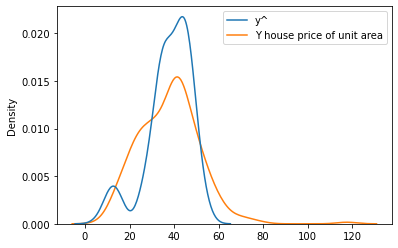

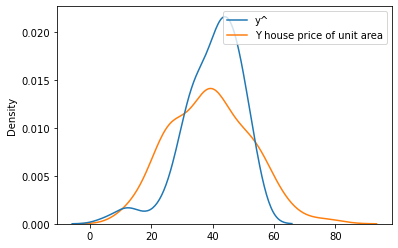

In [31]:
plt.figure()
sns.kdeplot(data=St[['y^']+vart])
plt.figure()
sns.kdeplot(data=Sv[['y^']+vart])